In [87]:
%pip install seaborn
# To avoid the deprecation warning
%pip install pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.utils import resample


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [88]:
# Import Datasets
launches = pd.read_csv('Launches.csv')
configs = pd.read_csv('Configs.csv')
families = pd.read_csv('Families.csv')
companies = pd.read_csv('Companies.csv')
locations = pd.read_csv('Locations.csv')
missions = pd.read_csv('Missions.csv')

As our dataset is split up between 6 csv files, the dataframe must combine the data from them. For that, we will use joins and, for them to work, the data types must be correctly aligned.

In [89]:
configs['Family Id'] = configs['Family Id'].astype(int)

rockets = pd.merge(configs, families, how = 'inner', on = 'Family Id')

launch_data = pd.merge(launches, locations, how = 'inner', left_on = 'Location', right_on = 'Orig_Addr')
launch_data = pd.merge(launch_data, rockets, how = 'inner', right_on = 'Config', left_on = 'Rocket Name')
launch_data = pd.merge(launch_data, companies, how = 'inner', left_on = 'Rocket Organisation', right_on = 'Company Name')
launch_data = pd.merge(launch_data, missions, how = 'inner', on = 'Launch Id')

Let's now consider the dataset info and all feature present after merging all csvs.

In [90]:
launch_data.describe()
launch_data.head()
launch_data.columns

Index(['Launch Id', 'Launch Time', 'Launch Status', 'Launch Suborbital',
       'Rocket Name', 'Rocket Organisation', 'Rocket Price',
       'Rocket Payload to LEO', 'Location', 'Launch Year', 'Launch Year Mon',
       'USD/kg to LEO', '2021 Mult', 'USD/kg to LEO CPI Adjusted',
       'Rocket Price CPI Adjusted', 'Dum', 'Orig_Addr', 'Country',
       'Country_Code', 'Lat', 'Lon', 'Operator', 'Launch Site',
       'Launch Site Lat', 'Launch Site Lon', 'Comb Launch Site',
       'Comb Launch Site Lat', 'Comb Launch Site Lon', 'Operator Lat',
       'Operator Lon', 'Family Id', 'No_x', 'Config', 'Status', 'Price',
       'Liftoff Thrust', 'Payload to LEO', 'Payload to GTO', 'Stages',
       'Strap-ons', 'Rocket Height', 'Fairing Diameter', 'Fairing Height',
       'Family', 'Missions', 'Successes', 'Partial Failures', 'Failures',
       'Success Streak', 'Success Rate', 'Company Name', 'Company Country',
       'Ownership', 'No_y', 'Payloads', 'Mass'],
      dtype='object')

Columns such as the launch id can be ignored, as they are not useful for our analysis. Duplicate rows should also be removed, as well as rows where there is lack of information.

In [91]:
launch_data = launch_data.drop_duplicates()
launch_data = launch_data.dropna()
launch_data = launch_data.drop(["Launch Id"], axis="columns")

As the following plot shows, we have a very imbalanced dataset when considering this specific fields.

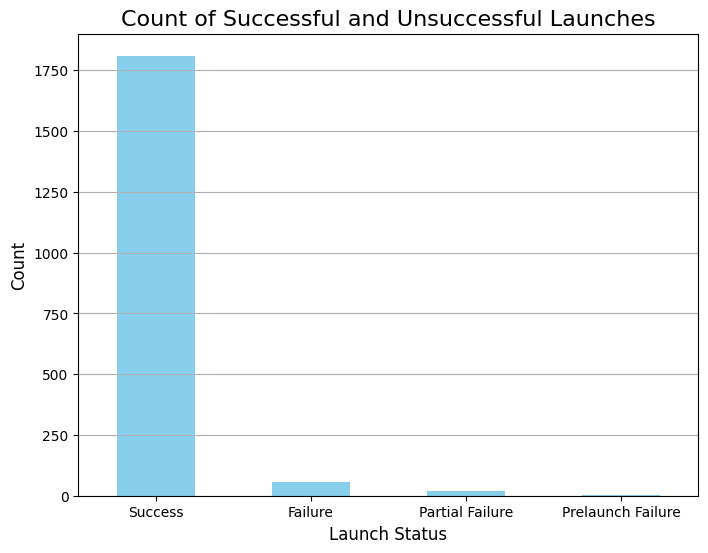

In [92]:
# Count the number of successful and unsuccessful launches
status_counts = launch_data['Launch Status'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
status_counts.plot(kind='bar', color=['skyblue'])
plt.title('Count of Successful and Unsuccessful Launches', fontsize=16)
plt.xlabel('Launch Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [102]:
launch_data['Launch Status'].value_counts()

Launch Status
Success              1810
Failure                56
Partial Failure        20
Prelaunch Failure       1
Name: count, dtype: int64

In order to lower its impact, there are a few approaches that can be taken into consiration. In this instance, we decided to go for under-sampling.

In [94]:

df_majority = launch_data[launch_data['Launch Status'] == 'Success']
df_minority = launch_data[launch_data['Launch Status'] != 'Success']

sample_size = int(len(df_majority)/16)
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=sample_size,     # match number in minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_minority, df_majority_downsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
balanced_status = df_balanced['Launch Status'].value_counts()

Let's run a visualization of the balanced dataset, in order to see what happens when we have a balanced dataset.

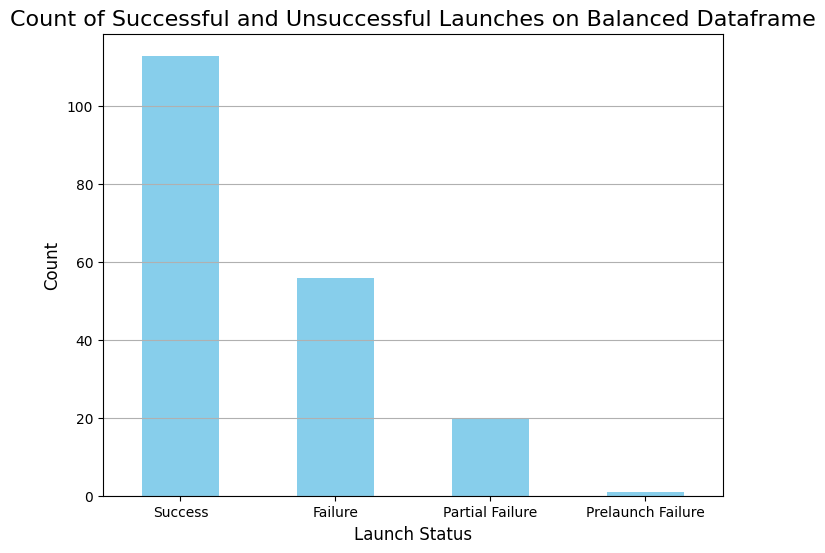

In [95]:
# Plot the histogram
plt.figure(figsize=(8, 6))
balanced_status.plot(kind='bar', color=['skyblue'])
plt.title('Count of Successful and Unsuccessful Launches on Balanced Dataframe', fontsize=16)
plt.xlabel('Launch Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [62]:
df_balanced['Launch Status'].value_counts()

Launch Status
Success              113
Failure               56
Partial Failure       20
Prelaunch Failure      1
Name: count, dtype: int64

### 1st Question: does the price influence the success of a Launch?

Let's follow an Hypothesis Testing.

Hypothesis
1) Null Hypothesis (Ho): Price has no influence on the success of a launch.
2) Alternative Hypothesis (Ha): Price influences positively the success of a launch. (Is there a correlation?)

Let's first run a boxplot to see the distribution of the data, check if there are any outliers and if their presence is significant.

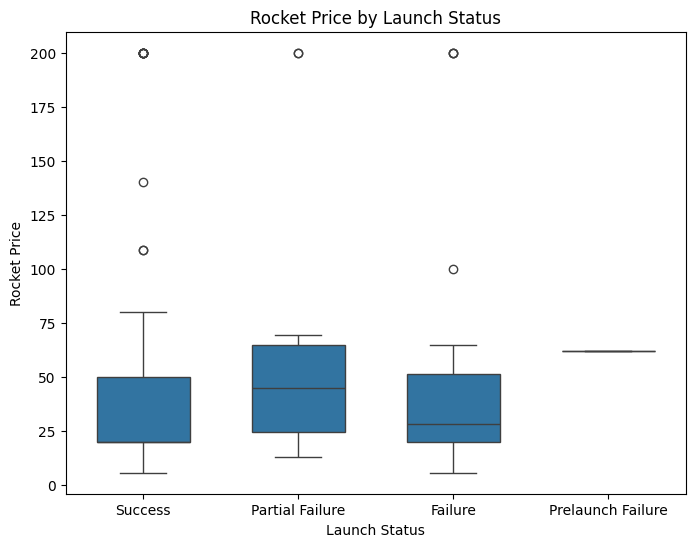

In [96]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Launch Status', y='Rocket Price', data=df_balanced, width=0.6)
plt.title('Rocket Price by Launch Status')
plt.xlabel('Launch Status')
plt.ylabel('Rocket Price')
plt.show()

The boxplot visualization suggests that rocket price is not a decisive factor in determining launch success, as failures happen across all price ranges.

To examine the relationship between rocket price and launch success, we conducted a point-biserial correlation test. This test is appropriate for analyzing the association between a continuous variable (rocket price) and a dichotomous variable (launch success: 0 or 1). You can know more about this specific test in the following link: https://www.statisticshowto.com/point-biserial-correlation/ 

In [97]:
rocket_prices = df_balanced['Rocket Price']
launch_success = (df_balanced['Launch Status'] == 'Success').astype(int)
df_balanced['Launch Success Binary'] = df_balanced['Launch Status'].apply(lambda x: 1 if x.lower() == 'success' else 0)

# Calculate point-biserial correlation
correlation, p_value = stats.pointbiserialr(launch_success, rocket_prices)

print(f"Correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between rocket price and launch success.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.")

Correlation coefficient: -0.0107
P-value: 0.8834
Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.


The results show:

- Correlation coefficient: -0.0107
- P-value: 0.8834

With a p-value of 0.8834, which is much larger than the conventional significance level of 0.05, we fail to reject the null hypothesis. This suggests that there is no statistically significant relationship between rocket price and launch success.

The correlation coefficient of -0.0107 indicates a very weak negative relationship between price and success. However, given the high p-value, this relationship is not statistically significant and is likely due to random chance rather than a true association in the population.

In conclusion, based on this point-biserial correlation test, we fail to reject the null hypothesis that there is no statistically significant relationship between rocket price and launch success. This suggests that there is no evidence to support the claim that rocket prices are directly related to launch success.

---

### 2nd Question: Is there any corporation more likely to succeed in a launch??

Let's follow a Hypothesis Testing, just as in the first question.

Hypothesis
1) Null Hypothesis (Ho): A rocket's corporation has no influence on the success of a launch.
2) Alternative Hypothesis (Ha): The corporation that fabricated the rocket influences positively the success of a launch. (Is there a correlation?)

We'll start with a simple groupby operation on the Launches data frame. We will group the data by the Rocket Organisation, and then count the number of Total launches for each organization, sum the number of Successful Launches, and provide the average number (Success Rate) of successful launches.

In [98]:
# Group the data by the 'Rocket Organisation' column and calculate the number of launches, successful launches, and success rate.
success_rate = (
    df_balanced.groupby('Rocket Organisation')['Launch Success Binary']
    .agg(['count', 'sum', 'mean'])
    .rename(columns={'count': 'Total Launches', 'sum': 'Successful Launches', 'mean': 'Success Rate'})
)

# Limit the data to only include organizations with at least 5 successful launches, in order to have a more meaningful analysis.
success_rate = success_rate[success_rate['Total Launches'] >= 5]

success_rate = success_rate.sort_values(by=['Success Rate'], ascending=[False])
success_rate.head()

,Total Launches,Successful Launches,Success Rate
Rocket Organisation,,,
SpaceX,14,11,0.785714
RVSN USSR,62,44,0.709677
Arianespace,18,12,0.666667
CASC,18,12,0.666667
International Launch Services,11,6,0.545455


Let's run a visualization.

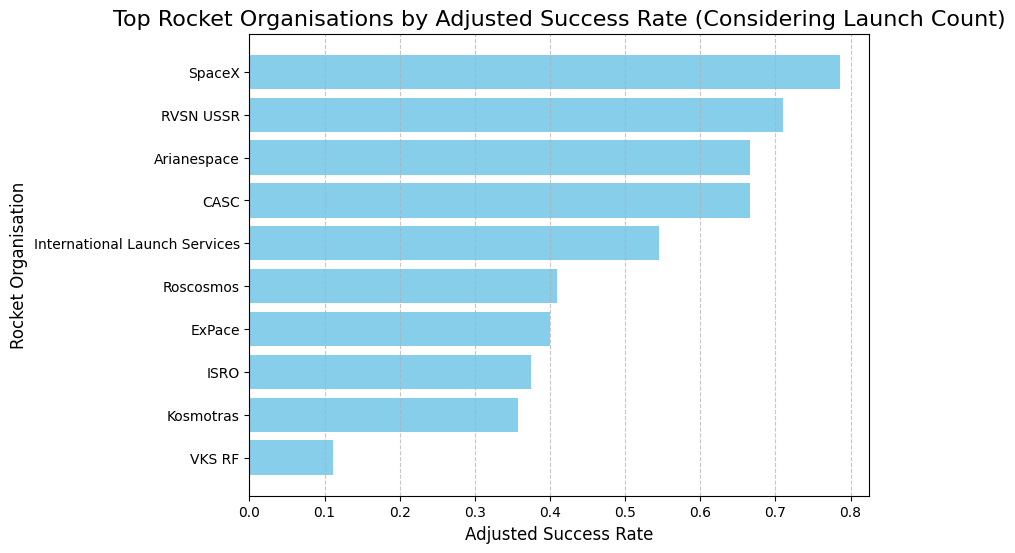

In [99]:
plt.figure(figsize=(8, 6))
plt.barh(success_rate.index, success_rate['Success Rate'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Top Rocket Organisations by Adjusted Success Rate (Considering Launch Count)', fontsize=16)
plt.xlabel('Adjusted Success Rate', fontsize=12)
plt.ylabel('Rocket Organisation', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The visualisation concludes that Eurockot is the most successful Rocket Organisation within this dataset, if we consider only the average of Successful Launches per Rocket Organisation.

Let's dive deeper to understand the data, and see if we can find some relationship between the Rocket's Organization and the launch success.

In [100]:
# Create a contingency table
contingency_table = pd.crosstab(df_balanced['Rocket Organisation'], df_balanced['Launch Success Binary'])

# Perform the test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.4f}, p-value: {p:.4f}")

# Interpret the results
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant relationship between rocket price and launch success.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.")

Chi-square statistic: 27.7555, p-value: 0.0098
Reject the null hypothesis: There is a significant relationship between rocket price and launch success.


To examine the relationship between corporation and launch success, we conducted a chi-square test. This test evaluates the independence of a feature (launch success: 0 or 1) from another (corporation). The results show:

- Chi-square statistic: 30.1258,
- P-value: 0.0027

With a p-value of 0.0027, which is exceptionally smaller than the conventional significance level of 0.05, the null hypothesis is rejected, meaning that launch success is, in fact, dependent on the corporation.

The Chi-square statistic of 30.1258 points towards a very strong relationship between corporation and success. However, given the high p-value, this relationship is not statistically significant and is likely due to random chance rather than a true association in the population.

In conclusion, based on this chi-square test and the respective statistical value and P-value, we can conclude that organization has a meaningful influence on launch success.

We can, however, still try to figure out which company is more likely to succeed according to both raw success rate and to residual.

In [101]:
success_rate['Confidence Interval'] = success_rate.apply(
    lambda row: (
        row['Success Rate'] - 1.96 * ((row['Success Rate'] * (1 - row['Success Rate'])) / row['Total Launches'])**0.5,
        row['Success Rate'] + 1.96 * ((row['Success Rate'] * (1 - row['Success Rate'])) / row['Total Launches'])**0.5,
    ),
    axis=1
)

contingency_table = pd.crosstab(df_balanced['Rocket Organisation'], df_balanced['Launch Success Binary'])

# Perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate residuals
residuals = (contingency_table - expected) / np.sqrt(expected)

# Sort residuals
residuals = residuals.sum(axis=1).sort_values(ascending=False)
print(residuals)

Rocket Organisation
VKS RF                           0.397749
Kosmotras                        0.243713
Roscosmos                        0.238713
ISRO                             0.170383
ExPace                           0.119375
International Launch Services    0.044809
Arianespace                     -0.083661
CASC                            -0.083661
Eurockot                        -0.085129
Northrop                        -0.111100
Starsem                         -0.111100
ULA                             -0.192432
SpaceX                          -0.195896
RVSN USSR                       -0.248112
dtype: float64


Before concluding anything, however, we must reason about the meaning of a high or low, positive or negative residual. The residual looks to highlight, in this case, that an organization sucess is more or less likely to be due to randomness and not due to the organization itself. Besides that, we must also understand that confidence intervals are meant to evaluate how consistent a feature is (in this case, the organization).

After performing the calculation of confidence intervals for each organization, performing a chi-square test and calulating residuals for each enterprise, we understand that:  

- If we are only taking into consideration raw success rate, SpaceX is a clear favorite succeed, as it holds a 85% success rate. 
- However, if we are taking into account both the residuals and the confidence intervals, VKS RF comes across as the most consistent organization even while not keeping a higher success-rate. 

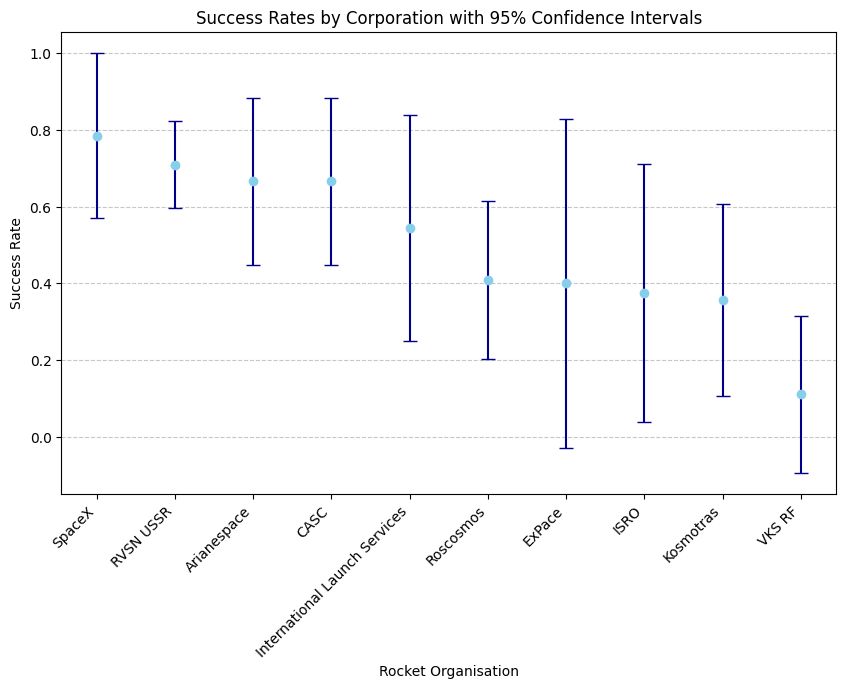

In [78]:
plt.figure(figsize=(10, 6))
plt.errorbar(
    success_rate.index,
    success_rate['Success Rate'],
    yerr=[
        success_rate['Success Rate'] - success_rate['Confidence Interval'].apply(lambda x: x[0]),
        success_rate['Confidence Interval'].apply(lambda x: x[1]) - success_rate['Success Rate']
    ],
    fmt='o', capsize=5, color='skyblue', ecolor='darkblue'
)
plt.title('Success Rates by Corporation with 95% Confidence Intervals')
plt.xlabel('Rocket Organisation')
plt.ylabel('Success Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Looking at the visualisation, SpaceX still takes the lead. 

---

### 3rd Question: Is there any country more likely to succeed in a launch?

In [73]:
success_rate = (
    df_balanced.groupby('Country')['Launch Success Binary']
    .agg(['count', 'sum', 'mean'])
    .rename(columns={'count': 'Total Launches', 'sum': 'Successful Launches', 'mean': 'Success Rate'})
)

success_rate = success_rate[success_rate['Total Launches'] >= 5]

success_rate = success_rate.sort_values(by=['Success Rate', 'Total Launches'], ascending=[False, False])

success_rate.head()

,Total Launches,Successful Launches,Success Rate
Country,,,
United States,18,15,0.833333
French Guiana,18,12,0.666667
Russia,56,36,0.642857
China,23,14,0.608696
Kazakhstan,67,33,0.492537


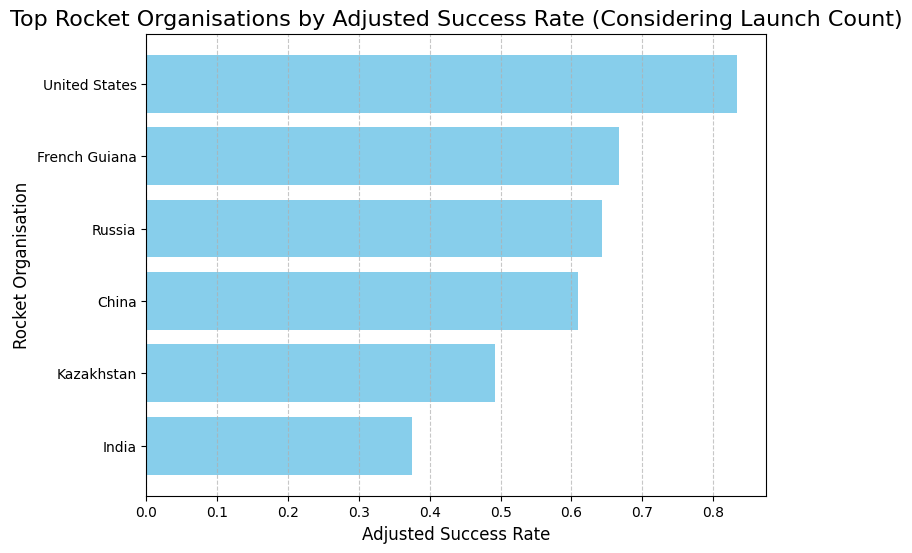

In [74]:
plt.figure(figsize=(8, 6))
# Create an horizontal bar chart
plt.barh(success_rate.index, success_rate['Success Rate'], color='skyblue')
# Invert the y-axis
plt.gca().invert_yaxis()
plt.title('Top Rocket Organisations by Adjusted Success Rate (Considering Launch Count)', fontsize=16)
plt.xlabel('Adjusted Success Rate', fontsize=12)
plt.ylabel('Rocket Organisation', fontsize=12)
# Add a grid
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [86]:
# Create a contingency table
contingency_table = pd.crosstab(df_balanced['Country'], df_balanced['Launch Success Binary'])

# Perform the test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.4f}, p-value: {p:.4f}")

# Interpret the results
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant relationship between rocket price and launch success.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.")

Chi-square statistic: 9.7005, p-value: 0.0842
Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.


In [85]:
success_rate['Confidence Interval'] = success_rate.apply(
    lambda row: (
        row['Success Rate'] - 1.96 * ((row['Success Rate'] * (1 - row['Success Rate'])) / row['Total Launches'])**0.5,
        row['Success Rate'] + 1.96 * ((row['Success Rate'] * (1 - row['Success Rate'])) / row['Total Launches'])**0.5,
    ),
    axis=1
)

contingency_table = pd.crosstab(df_balanced['Country'], df_balanced['Launch Success Binary'])

# Perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate residuals
residuals = (contingency_table - expected) / np.sqrt(expected)

# Sort residuals
residuals = residuals.sum(axis=1).sort_values(ascending=False)
print(residuals)

Country
Kazakhstan       0.229332
India            0.170383
China           -0.018352
French Guiana   -0.083661
Russia          -0.098719
United States   -0.277510
dtype: float64


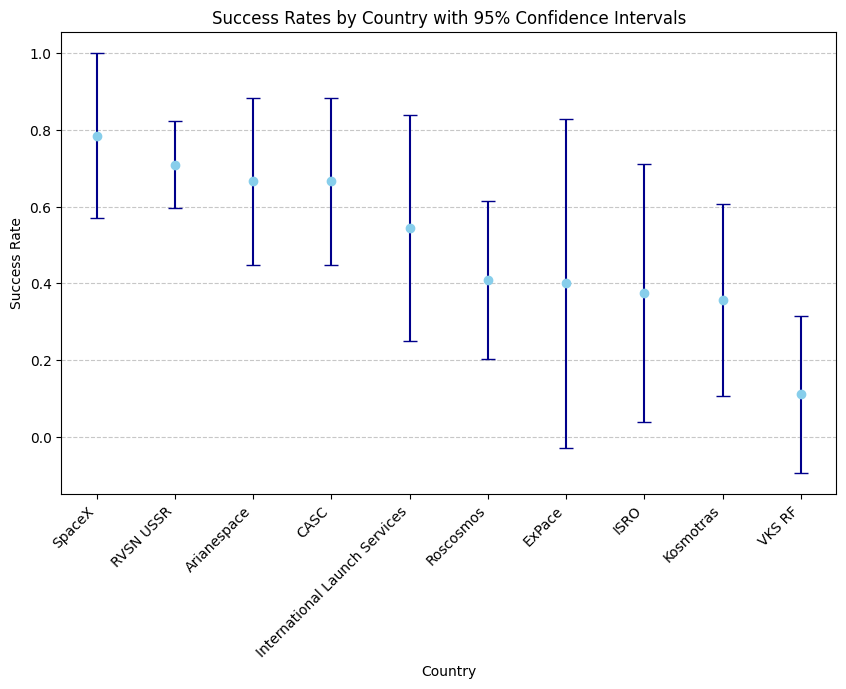

In [84]:
plt.figure(figsize=(10, 6))
plt.errorbar(
    success_rate.index,
    success_rate['Success Rate'],
    yerr=[
        success_rate['Success Rate'] - success_rate['Confidence Interval'].apply(lambda x: x[0]),
        success_rate['Confidence Interval'].apply(lambda x: x[1]) - success_rate['Success Rate']
    ],
    fmt='o', capsize=5, color='skyblue', ecolor='darkblue'
)
plt.title('Success Rates by Country with 95% Confidence Intervals')
plt.xlabel('Country')
plt.ylabel('Success Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
